### Look at Aeronet-OC and sensor AOD during Wildfires

In [1]:
#import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.patches as patches

#### 1. Identify dates of wildfire over maryland with AQNow data

In [2]:
# Load in AQ data: https://www.epa.gov/outdoor-air-quality-data/air-data-daily-air-quality-tracker
fn = '/panfs/ccds02/nobackup/people/slsmit34/Insitu/AQ_Data/ad_aqi_tracker_data.csv'
aqi = pd.read_csv(fn)
aqi.head()

,Date,PM2.5 AQI Value,Site Name,Site ID,Source,20-year High (2000-2019),20-year Low (2000-2019),5-year Average (2015-2019),Date of 20-year High,Date of 20-year Low
0,01/01/2023,35,Lake Montebello,24-510-5253,AQS,155,23,40.4,01/01/2000,01/01/2019
1,01/02/2023,58,Lake Montebello,24-510-5253,AQS,92,18,48.6,01/02/2000,01/02/2012
2,01/03/2023,58,Howard County Near Road,24-027-0006,AQS,115,20,51.8,01/03/2004,01/03/2012
3,01/04/2023,51,Lake Montebello,24-510-5253,AQS,89,19,34.0,01/04/2004,01/04/2017
4,01/05/2023,36,Howard County Near Road,24-027-0006,AQS,95,24,27.2,01/05/2001,01/05/2018


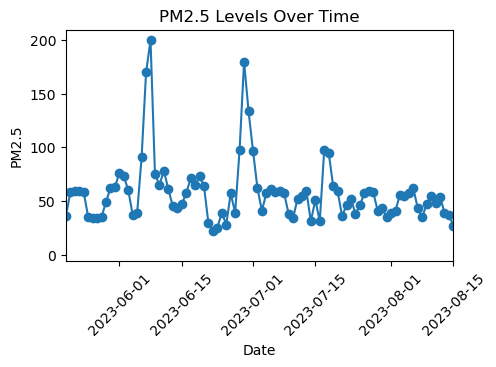

In [3]:
# Plot 'PM2.4' against 'Date'
aqi['Date'] = pd.to_datetime(aqi['Date'])
plt.figure(figsize=(5,3))
try: 
    plt.plot(aqi['Date'], aqi[' AQI Value'], marker='o', linestyle='-')
    plt.title('PM2.5 + Ozone AQI Levels Over Time')
    plt.ylabel('PM2.5 + Ozone AQI')
except: 
    aqi['PM2.5 AQI Value'] = aqi['PM2.5 AQI Value'].replace('.', pd.NA) 
    aqi['PM2.5 AQI Value'] = pd.to_numeric(aqi['PM2.5 AQI Value'])
    plt.plot(aqi['Date'], aqi['PM2.5 AQI Value'], marker='o', linestyle='-')
    plt.title('PM2.5 Levels Over Time')
    plt.ylabel('PM2.5')
plt.xlabel('Date')
plt.xticks(rotation = 45)
#plt.grid(True)
startDate = pd.to_datetime('05-20-2023')
endDate = pd.to_datetime('08-15-2023')
plt.xlim(startDate, endDate)
plt.show()

### Get AERONET of top days

In [4]:
from datetime import datetime
doi = '2023-06-29'
aero_fn = '/panfs/ccds02/nobackup/people/slsmit34/Insitu/Aeronet/AOD/AOD_L2_2023_wholeYear_CB.csv'
aero = pd.read_csv(aero_fn)
aero['Date(dd:mm:yyyy)'] = pd.to_datetime(aero['Date(dd:mm:yyyy)'], format='%d:%m:%Y')
aero['Time(hh:mm:ss)'] = pd.to_datetime(aero['Time(hh:mm:ss)'], format='%I:%M:%S %p').dt.time
aero['Datetime'] = aero.apply(lambda row: datetime.combine(row['Date(dd:mm:yyyy)'], row['Time(hh:mm:ss)']), axis=1)
aero.replace(-999, np.nan, inplace=True)
for col in aero.columns:
    if 'AOD' in col:
        #print(col)
        pass;
aero['AOD_560nm']

0        0.025845
1        0.021671
2        0.021569
3        0.021365
4        0.021566
           ...   
14227    0.168801
14228    0.165847
14229    0.182265
14230    0.162188
14231    0.170075
Name: AOD_560nm, Length: 14232, dtype: float64

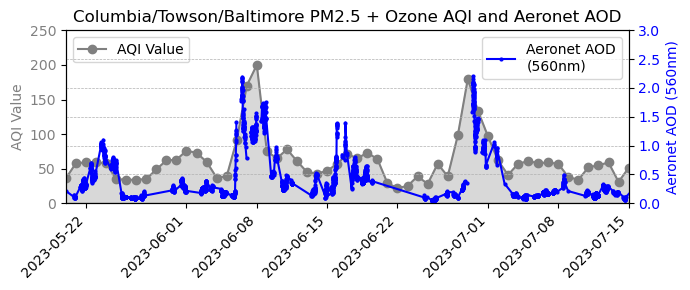

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

wvl = 560
# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(7, 3))

# Plot the AQI Value line and shade under it
try: 
    ax1.plot(aqi['Date'], aqi[' AQI Value'], marker='o', linestyle='-', color='gray', label='AQI Value')
    ax1.fill_between(aqi['Date'], aqi[' AQI Value'], color='gray', alpha=0.3)  # Shading under the line
except: 
    ax1.plot(aqi['Date'], aqi['PM2.5 AQI Value'], marker='o', linestyle='-', color='gray', label='AQI Value')
    ax1.fill_between(aqi['Date'], aqi['PM2.5 AQI Value'], color='gray', alpha=0.3)  # Shading under the line
ax1.set_ylabel('AQI Value', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_ylim(0, 250)

# Create a second y-axis to plot 'AOD_560nm'
ax2 = ax1.twinx()
ax2.plot(aero['Datetime'], aero[f'AOD_{wvl}nm'], linestyle='-', color='b', marker='o', markersize=2, alpha=1, label=f'Aeronet AOD\n({wvl}nm)')
ax2.set_xlabel('Date')
ax2.set_ylabel(f'Aeronet AOD ({wvl}nm)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_xlim(pd.to_datetime('2023-05-20'), pd.to_datetime('2023-07-15'))
ax2.set_ylim(0, 3)

# Rotate x-axis ticks for ax1
fig.autofmt_xdate()  # Automatically rotates x-tick labels

# Alternatively, you can directly use:
ax1.tick_params(axis='x', rotation=45)

# Show legends
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')

# Add a title and grid
plt.title('Columbia/Towson/Baltimore PM2.5 + Ozone AQI and Aeronet AOD')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Get satellite scenes w/ AOD:
MODIS = MCD19A2

NOAA VIIRS = https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01446

In [6]:
import os
import earthaccess
from earthaccess import DataGranules, DataCollections
import pandas as pd
import geopandas as gp
import xarray as xr
import sys
from usgs import api
earthaccess.login(strategy = 'netrc')

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# POINT
year = 2023
results = earthaccess.search_data(
    short_name="MCD19A2",
    #point=(-76.3489,39.12351),
    bounding_box = (-77.84793090820312,36.464637756347656,-75.89791870117188,39.619041442871094),   
    #bounding_box = (-76.107788,39.38053,-76.05423,39.42190), #if using bounding box
    temporal=(f'{year}-05-22',f'{year}-07-15'), 
    #cloud_cover = (0,50), #give min and max cloud cover range
    count=800
)
sat = 'MODIS_AOD'
results_df = pd.json_normalize(results)
results_df.head()

Granules found: 108


,size,meta.concept-type,meta.concept-id,meta.revision-id,meta.native-id,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,umm.TemporalExtent.RangeDateTime.BeginningDateTime,...,umm.CloudCover,umm.Projects,umm.DataGranule.DayNightFlag,umm.DataGranule.Identifiers,umm.DataGranule.ProductionDateTime,umm.DataGranule.ArchiveAndDistributionInformation,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version
0,4.44277,granule,G2696344219-LPCLOUD,1,MCD19A2.A2023142.h12v05.061.2023143154917,C2324689816-LPCLOUD,LPCLOUD,application/echo10+xml,2023-05-23T18:14:57.971Z,2023-05-22T13:30:00.000Z,...,0.0,"[{'ShortName': 'Not provided', 'Campaigns': ['...",Day,[{'Identifier': 'MCD19A2.A2023142.h12v05.061.2...,2023-05-23T15:49:17.000Z,"[{'Name': 'Not provided', 'Size': 4.44277, 'Si...","[{'ShortName': 'Terra', 'Instruments': [{'Shor...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
1,7.23886,granule,G2696345902-LPCLOUD,1,MCD19A2.A2023142.h11v05.061.2023143155701,C2324689816-LPCLOUD,LPCLOUD,application/echo10+xml,2023-05-23T18:17:44.746Z,2023-05-22T15:10:00.000Z,...,0.0,"[{'ShortName': 'Not provided', 'Campaigns': ['...",Day,[{'Identifier': 'MCD19A2.A2023142.h11v05.061.2...,2023-05-23T15:57:01.000Z,"[{'Name': 'Not provided', 'Size': 7.23886, 'Si...","[{'ShortName': 'Terra', 'Instruments': [{'Shor...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
2,4.60818,granule,G2697219715-LPCLOUD,1,MCD19A2.A2023143.h12v05.061.2023144155719,C2324689816-LPCLOUD,LPCLOUD,application/echo10+xml,2023-05-24T18:24:05.717Z,2023-05-23T14:10:00.000Z,...,0.0,"[{'ShortName': 'Not provided', 'Campaigns': ['...",Day,[{'Identifier': 'MCD19A2.A2023143.h12v05.061.2...,2023-05-24T15:57:19.000Z,"[{'Name': 'Not provided', 'Size': 4.60818, 'Si...","[{'ShortName': 'Terra', 'Instruments': [{'Shor...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
3,7.72956,granule,G2697220054-LPCLOUD,1,MCD19A2.A2023143.h11v05.061.2023144155614,C2324689816-LPCLOUD,LPCLOUD,application/echo10+xml,2023-05-24T18:24:46.041Z,2023-05-23T14:15:00.000Z,...,0.0,"[{'ShortName': 'Not provided', 'Campaigns': ['...",Day,[{'Identifier': 'MCD19A2.A2023143.h11v05.061.2...,2023-05-24T15:56:14.000Z,"[{'Name': 'Not provided', 'Size': 7.72956, 'Si...","[{'ShortName': 'Terra', 'Instruments': [{'Shor...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6
4,10.05380,granule,G2697770410-LPCLOUD,1,MCD19A2.A2023144.h11v05.061.2023145155758,C2324689816-LPCLOUD,LPCLOUD,application/echo10+xml,2023-05-25T17:42:52.064Z,2023-05-24T14:50:00.000Z,...,0.0,"[{'ShortName': 'Not provided', 'Campaigns': ['...",Day,[{'Identifier': 'MCD19A2.A2023144.h11v05.061.2...,2023-05-25T15:57:58.000Z,"[{'Name': 'Not provided', 'Size': 10.0538, 'Si...","[{'ShortName': 'Terra', 'Instruments': [{'Shor...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6


In [8]:
i = 0
while i < len(results):
    #download file:
    print(f'[{i}] Processing...')
    try: earthaccess.download(results[i],f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD')
    except: 
        print('---failed... retrying')
        earthaccess.download(results[i],f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD')
    i = i+1

[0] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2399.49it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 145.90it/s]


File MCD19A2.A2023142.h12v05.061.2023143154917.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]


[1] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2683.50it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 363.84it/s]


File MCD19A2.A2023142.h11v05.061.2023143155701.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 27594.11it/s]


[2] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5497.12it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 14513.16it/s]


File MCD19A2.A2023143.h12v05.061.2023144155719.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]


[3] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4457.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1523.54it/s]


File MCD19A2.A2023143.h11v05.061.2023144155614.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 32768.00it/s]


[4] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2878.73it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]


File MCD19A2.A2023144.h11v05.061.2023145155758.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 30840.47it/s]


[5] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3079.52it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]


File MCD19A2.A2023144.h12v05.061.2023145160139.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[6] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5059.47it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]


File MCD19A2.A2023145.h12v05.061.2023146160740.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 33288.13it/s]


[7] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5275.85it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]


File MCD19A2.A2023145.h11v05.061.2023146161312.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[8] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5482.75it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 21732.15it/s]


File MCD19A2.A2023146.h12v05.061.2023147162204.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34100.03it/s]


[9] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4987.28it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]


File MCD19A2.A2023146.h11v05.061.2023147162758.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[10] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5592.41it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]


File MCD19A2.A2023147.h12v05.061.2023148162216.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]


[11] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1665.07it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3243.85it/s]


File MCD19A2.A2023147.h11v05.061.2023148162300.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


[12] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2737.80it/s]


File MCD19A2.A2023148.h12v05.061.2023149164321.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22550.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


[13] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2348.43it/s]


File MCD19A2.A2023148.h11v05.061.2023149164155.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[14] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6241.52it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3385.23it/s]


File MCD19A2.A2023149.h12v05.061.2023150170107.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 30615.36it/s]


[15] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2908.67it/s]


File MCD19A2.A2023149.h11v05.061.2023150170229.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22550.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[16] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5562.74it/s]


File MCD19A2.A2023150.h12v05.061.2023151165829.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


[17] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2341.88it/s]


File MCD19A2.A2023150.h11v05.061.2023151165956.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


[18] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3432.33it/s]


File MCD19A2.A2023151.h12v05.061.2023153170655.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25115.59it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[19] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6384.02it/s]


File MCD19A2.A2023151.h11v05.061.2023153170551.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[20] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6533.18it/s]


File MCD19A2.A2023152.h12v05.061.2023153190459.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[21] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5614.86it/s]


File MCD19A2.A2023152.h11v05.061.2023153185546.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[22] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1991.60it/s]


File MCD19A2.A2023153.h12v05.061.2023154170639.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22550.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[23] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2069.22it/s]


File MCD19A2.A2023153.h11v05.061.2023154170437.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[24] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3949.44it/s]


File MCD19A2.A2023154.h12v05.061.2023155162530.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


[25] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4092.00it/s]


File MCD19A2.A2023154.h11v05.061.2023155161840.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[26] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6452.78it/s]


File MCD19A2.A2023155.h12v05.061.2023156203122.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[27] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2113.00it/s]


File MCD19A2.A2023155.h11v05.061.2023156204142.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24672.38it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38836.15it/s]


[28] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1952.66it/s]


File MCD19A2.A2023156.h11v05.061.2023160151032.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24672.38it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[29] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6307.22it/s]


File MCD19A2.A2023156.h12v05.061.2023160153630.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[30] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1729.61it/s]


File MCD19A2.A2023157.h12v05.061.2023160155510.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[31] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2146.52it/s]


File MCD19A2.A2023157.h11v05.061.2023160154625.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[32] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2605.16it/s]


File MCD19A2.A2023158.h11v05.061.2023160162248.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[33] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1979.38it/s]


File MCD19A2.A2023158.h12v05.061.2023160163111.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[34] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6413.31it/s]


File MCD19A2.A2023159.h12v05.061.2023163180415.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[35] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6615.62it/s]


File MCD19A2.A2023159.h11v05.061.2023163180336.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[36] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6335.81it/s]


File MCD19A2.A2023160.h12v05.061.2023163195743.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[37] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6462.72it/s]


File MCD19A2.A2023160.h11v05.061.2023163200259.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 29959.31it/s]


[38] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6393.76it/s]


File MCD19A2.A2023161.h12v05.061.2023163203528.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


[39] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2647.92it/s]


File MCD19A2.A2023161.h11v05.061.2023163204814.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[40] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2387.20it/s]


File MCD19A2.A2023162.h12v05.061.2023163212208.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[41] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3721.65it/s]


File MCD19A2.A2023162.h11v05.061.2023163220444.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[42] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1597.83it/s]


File MCD19A2.A2023163.h12v05.061.2023164162303.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[43] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3799.19it/s]


File MCD19A2.A2023163.h11v05.061.2023164162150.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25575.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[44] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5753.50it/s]


File MCD19A2.A2023164.h12v05.061.2023165173930.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[45] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3855.06it/s]


File MCD19A2.A2023164.h11v05.061.2023165171616.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[46] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2053.01it/s]


File MCD19A2.A2023165.h12v05.061.2023166171903.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25115.59it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 33825.03it/s]


[47] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5817.34it/s]


File MCD19A2.A2023165.h11v05.061.2023166171535.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25115.59it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[48] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5322.72it/s]


File MCD19A2.A2023166.h12v05.061.2023167162825.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[49] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4044.65it/s]


File MCD19A2.A2023166.h11v05.061.2023167165005.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[50] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]


File MCD19A2.A2023167.h12v05.061.2023168184759.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[51] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4148.67it/s]


File MCD19A2.A2023167.h11v05.061.2023168184700.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[52] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4284.27it/s]


File MCD19A2.A2023168.h12v05.061.2023169162716.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[53] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3669.56it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2063.11it/s]

File MCD19A2.A2023168.h11v05.061.2023169163108.hdf already downloaded



COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 27962.03it/s]


[54] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2207.53it/s]


File MCD19A2.A2023169.h12v05.061.2023170162445.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]


[55] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2387.20it/s]


File MCD19A2.A2023169.h11v05.061.2023170162125.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


[56] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3809.54it/s]


File MCD19A2.A2023170.h11v05.061.2023171175041.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[57] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6875.91it/s]


File MCD19A2.A2023170.h12v05.061.2023171180436.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[58] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3975.64it/s]


File MCD19A2.A2023171.h12v05.061.2023172170509.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23696.63it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[59] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5801.25it/s]


File MCD19A2.A2023171.h11v05.061.2023172171317.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[60] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1448.81it/s]


File MCD19A2.A2023172.h12v05.061.2023173163713.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[61] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2439.97it/s]


File MCD19A2.A2023172.h11v05.061.2023173163439.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]


[62] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2926.94it/s]


File MCD19A2.A2023173.h12v05.061.2023174162905.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]

[63] Processing...
 Getting 1 granules, approx download size: 0.01 GB



QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6432.98it/s]


File MCD19A2.A2023173.h11v05.061.2023174163737.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]


[64] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2003.97it/s]


File MCD19A2.A2023174.h12v05.061.2023175163408.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23431.87it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


[65] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2246.55it/s]


File MCD19A2.A2023174.h11v05.061.2023175163012.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24105.20it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[66] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6364.65it/s]


File MCD19A2.A2023175.h12v05.061.2023176162144.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[67] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6574.14it/s]


File MCD19A2.A2023175.h11v05.061.2023176162611.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


[68] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2303.30it/s]

File MCD19A2.A2023176.h12v05.061.2023178021648.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 25115.59it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


[69] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6523.02it/s]


File MCD19A2.A2023176.h11v05.061.2023178021408.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[70] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]


File MCD19A2.A2023177.h12v05.061.2023178180658.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 21845.33it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]


[71] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6223.00it/s]


File MCD19A2.A2023177.h11v05.061.2023178175347.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34952.53it/s]


[72] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3830.41it/s]

File MCD19A2.A2023178.h12v05.061.2023179170846.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[73] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File MCD19A2.A2023178.h11v05.061.2023179171959.hdf already downloaded


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1960.87it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 39199.10it/s]


[74] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File MCD19A2.A2023179.h11v05.061.2023180184737.hdf already downloaded


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2195.97it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[75] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5983.32it/s]


File MCD19A2.A2023179.h12v05.061.2023180190812.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22075.28it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34952.53it/s]


[76] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2170.96it/s]


File MCD19A2.A2023180.h12v05.061.2023187005525.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22795.13it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 27060.03it/s]


[77] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2030.16it/s]


File MCD19A2.A2023180.h11v05.061.2023187010207.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[78] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6563.86it/s]


File MCD19A2.A2023181.h12v05.061.2023188091733.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


[79] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1892.74it/s]


File MCD19A2.A2023181.h11v05.061.2023188085957.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22795.13it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[80] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2511.56it/s]


File MCD19A2.A2023182.h12v05.061.2023189063424.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[81] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6482.70it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 614.82it/s]


File MCD19A2.A2023182.h11v05.061.2023189063440.hdf already downloaded


COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[82] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1569.14it/s]


File MCD19A2.A2023183.h12v05.061.2023189182337.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23696.63it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


[83] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3196.88it/s]


File MCD19A2.A2023183.h11v05.061.2023189180631.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[84] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1326.47it/s]


File MCD19A2.A2023184.h12v05.061.2023190130736.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 34379.54it/s]


[85] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2664.74it/s]


File MCD19A2.A2023184.h11v05.061.2023190131731.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[86] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2160.90it/s]


File MCD19A2.A2023185.h12v05.061.2023191041411.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23696.63it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]


[87] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2444.23it/s]

File MCD19A2.A2023185.h11v05.061.2023191051022.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36157.79it/s]


[88] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3916.25it/s]

File MCD19A2.A2023186.h12v05.061.2023191173442.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35848.75it/s]


[89] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2624.72it/s]


File MCD19A2.A2023186.h11v05.061.2023191180632.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]


[90] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6668.21it/s]

File MCD19A2.A2023187.h12v05.061.2023191234149.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22310.13it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38836.15it/s]


[91] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4262.50it/s]


File MCD19A2.A2023187.h11v05.061.2023192000732.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[92] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File MCD19A2.A2023188.h12v05.061.2023192215723.hdf already downloaded

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1611.95it/s]


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]


[93] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6765.01it/s]


File MCD19A2.A2023188.h11v05.061.2023192221450.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35544.95it/s]


[94] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2059.06it/s]


File MCD19A2.A2023189.h12v05.061.2023193005922.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[95] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2187.95it/s]


File MCD19A2.A2023189.h11v05.061.2023193011200.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


[96] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 3328.81it/s]


File MCD19A2.A2023190.h12v05.061.2023193082818.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[97] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4165.15it/s]


File MCD19A2.A2023190.h11v05.061.2023193085207.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2611.65it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[98] Processing...
 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1525.76it/s]


File MCD19A2.A2023191.h12v05.061.2023193133304.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38479.85it/s]


[99] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 4048.56it/s]


File MCD19A2.A2023191.h11v05.061.2023193132856.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24672.38it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[100] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1522.99it/s]


File MCD19A2.A2023192.h12v05.061.2023199204203.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[101] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2528.21it/s]


File MCD19A2.A2023192.h11v05.061.2023199204843.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[102] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2468.69it/s]


File MCD19A2.A2023193.h12v05.061.2023199221548.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 35246.25it/s]


[103] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2985.27it/s]


File MCD19A2.A2023193.h11v05.061.2023199212816.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37449.14it/s]


[104] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2372.34it/s]


File MCD19A2.A2023194.h12v05.061.2023199232955.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 22550.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]


[105] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 5940.94it/s]

File MCD19A2.A2023194.h11v05.061.2023200000718.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 37786.52it/s]


[106] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2673.23it/s]


File MCD19A2.A2023195.h12v05.061.2023200003956.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 24528.09it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


[107] Processing...
 Getting 1 granules, approx download size: 0.01 GB


QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2489.20it/s]

File MCD19A2.A2023195.h11v05.061.2023200015449.hdf already downloaded



PROCESSING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 36792.14it/s]


In [9]:
#Load in a scene
modis_dir = '/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD'
#fn = f'{modis_dir}/MCD19A2.A2023153.h11v05.061.2023154170437.hdf'
fn = f'{modis_dir}/manual/MCD19A2.A2023180.h12v05.061.2023187005525.hdf'
import rioxarray
ds = rioxarray.open_rasterio(fn)
ds = ds[0]
import xarray as xr
from pyproj import CRS, Transformer
# Define the Sinusoidal projection using the PROJ string
from pyproj import CRS
wkt = ds.spatial_ref.attrs['crs_wkt']
crs = CRS.from_wkt(wkt)
sinu_proj =crs.to_proj4()  # Print out the PROJ.4 string
wgs84_proj = "EPSG:4326"
# Create a transformer object
transformer = Transformer.from_crs(sinu_proj, wgs84_proj, always_xy=True)
lon, lat = transformer.transform(ds.x.values, ds.y.values)
# Add the transformed coordinates back to the dataset
ds['longitude'] = (('x'), lon.reshape(ds.y.size))  # Ensure the dimensions match
ds['latitude'] = (('y'), lat.reshape(ds.x.size))
ds = ds.assign_coords(latitude=ds['latitude'], longitude=ds['longitude'])
#scale Factor
scaleFactor = .001
ds['Optical_Depth_055'] = ds['Optical_Depth_055']*scaleFactor
ds['Optical_Depth_055'].values[ds['Optical_Depth_055'].values == -28.672] = np.nan

ds

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<xarray.Dataset> Size: 150MB
Dimensions:              (band: 4, x: 1200, y: 1200)
Coordinates:
  * band                 (band) int64 32B 1 2 3 4
  * x                    (x) float64 10kB -6.671e+06 -6.67e+06 ... -5.56e+06
  * y                    (y) float64 10kB 4.447e+06 4.446e+06 ... 3.336e+06
    spatial_ref          int64 8B 0
    longitude            (x) float64 10kB -78.31 -78.29 -78.27 ... -57.76 -57.74
    latitude             (y) float64 10kB 40.0 39.99 39.98 ... 30.02 30.01 30.0
Data variables:
    Optical_Depth_047    (band, y, x) int16 12MB ...
    Optical_Depth_055    (band, y, x) float64 46MB nan nan nan ... nan nan nan
    AOD_Uncertainty      (band, y, x) int16 12MB ...
    Column_WV            (band, y, x) int16 12MB ...
    AngstromExp_470-780  (band, y, x) int16 12MB ...
    AOD_QA               (band, y, x) uint16 12MB ...
    FineModeFraction     (band, y, x) float32 23MB ...
    Injection_Height     (band, y, x) float32 23MB ...
Attributes: (12/85)
    ADDITIONALLAYERS:                   5
    ALGORITHMPACKAGEACCEPTANCEDATE:     TBD
    ALGORITHMPACKAGEMATURITYCODE:       Preliminary
    ALGORITHMPACKAGENAME:               MOD_PR19
    ALGORITHMPACKAGEVERSION:            2.0
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ...                                 ...
    TileID:                             51012005
    TOTALADDITIONALOBSERVATIONS:        404356
    TOTALOBSERVATIONS:                  7486712
    VERSIONID:                          61
    VERTICALTILENUMBER:                 5
    WESTBOUNDINGCOORDINATE:             -78.3244373487825

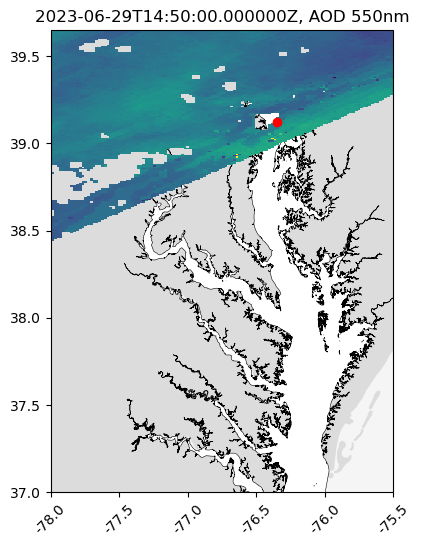

In [10]:
# Create a plot
numOI = 1
rrs_data = ds['Optical_Depth_055'][numOI,:,:]
latitude = rrs_data['latitude'].values
longitude = rrs_data['longitude'].values
date = ds.attrs[f'EQUATORCROSSINGDATE.1']
timeInfo = ds.attrs['GRANULEBEGINNINGDATETIME']
split_times = timeInfo.split(', ')

# Plot
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor('whitesmoke')
# shapefile
shapefile_path = f'/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_250m/Composite/Chesapeake_Bay_Shoreline_High_Resolution.shp'
gdf = gpd.read_file(shapefile_path)
gdf.boundary.plot(ax=ax, facecolor='white', edgecolor='black', alpha=1, linewidth=0.4 , zorder = 1)
im = ax.pcolormesh(longitude, latitude, rrs_data, transform=ccrs.PlateCarree(), zorder = 2)  
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black',color = 'gainsboro')
# Set title and labels
plt.title(f'{split_times[numOI]}, AOD 550nm')
aer_lon = -76.34890 #aero
aer_lat = 39.12351 #aero
plt.scatter(aer_lon,aer_lat, c = 'r', zorder = 2)
#crop
min_lon, max_lon = -76.6, -75.875  
min_lat, max_lat = 38.9, 39.65  
plt.ylim(min_lat,max_lat)
plt.xlim(min_lon,max_lon)
xticks = np.arange(-78, -75, 0.5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_xticklabels(xticks, rotation=45)
ax.set_yticks(np.arange(37, 40, 0.5), crs=ccrs.PlateCarree())
plt.show()

In [235]:
#Get single pt
aer_lat, aer_lon = 39.12351, -76.3489
split_times[numOI]
listAOD = []
listDate = []
listTime = []
#Loop
#1. get x and y index near aerlat/lon
x_index = (np.abs(ds.coords['longitude'].values - aer_lon)).argmin()
y_index = (np.abs(ds.coords['latitude'].values - aer_lat)).argmin()
nearest_x = ds.coords['longitude'].values[x_index]
nearest_y = ds.coords['latitude'].values[y_index]
print(f"({aer_lat}, {aer_lon}) --> ({nearest_y}, {nearest_x}) : ({y_index}, {x_index})")
#2. get aodval
value = ds['Optical_Depth_055'].isel(band=1, y=y_index, x=x_index)
aod_value = value.values.item()  # .item() is used to get the scalar from the array
print(f"AOD_550 at lat={aer_lat}, lon={aer_lon}: {aod_value}")
#append to listAOD, listDate,listTime
dateTimeStr = split_times[numOI].split('T')
date = dateTimeStr[0]
time = dateTimeStr[1][0:8]
listAOD.append(aod_value)
listDate.append(date)
listTime.append(time)

(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
AOD_550 at lat=39.12351, lon=-76.3489: 1.199


### Loop thru downloaded files and get value at aeronet

In [12]:
#Import packages
import rioxarray
import xarray as xr
from pyproj import CRS, Transformer
from pyproj import CRS

#Constants and lists
aer_lat, aer_lon = 39.12351, -76.3489
listAOD = []
listDate = []
listTime = []
modis_dir = '/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD'
i = 1

#Load in scenes
for filename in os.listdir(modis_dir):
    if os.path.isfile(os.path.join(modis_dir, filename)):  # Check if it's a file
        fn = f'{modis_dir}/{filename}'
        print(fn)
        ds = rioxarray.open_rasterio(fn) #open file
        ds = ds[0]
        print(f'\n({i}): [[RUNNING {filename}]]')
        #get datetime
        date = ds.attrs[f'EQUATORCROSSINGDATE.1']
        timeInfo = ds.attrs['GRANULEBEGINNINGDATETIME']
        split_times = timeInfo.split(', ')
        
        #convert sinusuidal
        wkt = ds.spatial_ref.attrs['crs_wkt']
        crs = CRS.from_wkt(wkt)
        sinu_proj =crs.to_proj4()  # Print out the PROJ.4 string
        wgs84_proj = "EPSG:4326"
        # Create a transformer object
        transformer = Transformer.from_crs(sinu_proj, wgs84_proj, always_xy=True)
        lon, lat = transformer.transform(ds.x.values, ds.y.values)
        # Add the transformed coordinates back to the dataset
        ds['longitude'] = (('x'), lon.reshape(ds.y.size))  # Ensure the dimensions match
        ds['latitude'] = (('y'), lat.reshape(ds.x.size))
        ds = ds.assign_coords(latitude=ds['latitude'], longitude=ds['longitude'])
        #scale Factor
        ds['Optical_Depth_055'] = ds['Optical_Depth_055']*scaleFactor
        ds['Optical_Depth_055'].values[ds['Optical_Depth_055'].values == -28.672] = np.nan
        i = i+1
        
        nums = np.arange(0,len(split_times),1)
        for numOI in nums: #loop thru bands (times)
            try:
                dateTimeStr = split_times[numOI].split('T')
                date = dateTimeStr[0]
                time = dateTimeStr[1][0:8]
                print(f' Running Band [{numOI}]: {time}')
                #Loop
                #1. get x and y index near aerlat/lon
                x_index = (np.abs(ds.coords['longitude'].values - aer_lon)).argmin()
                y_index = (np.abs(ds.coords['latitude'].values - aer_lat)).argmin()
                nearest_x = ds.coords['longitude'].values[x_index]
                nearest_y = ds.coords['latitude'].values[y_index]
                print(f"          a.({aer_lat}, {aer_lon}) --> ({nearest_y}, {nearest_x}) : ({y_index}, {x_index})")
                #2. get aodval
                value = ds['Optical_Depth_055'].isel(band=numOI, y=y_index, x=x_index)
                aod_value = value.values.item()  # .item() is used to get the scalar from the array
                print(f"          b. AOD_550 at lat={aer_lat}, lon={aer_lon}: [{aod_value}]")
                #append to listAOD, listDate,listTime
                listAOD.append(aod_value)
                listDate.append(date)
                listTime.append(time)
            except: print(f'     BAND FAILED')
            

/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023148.h12v05.061.2023149164321.hdf

(1): [[RUNNING MCD19A2.A2023148.h12v05.061.2023149164321.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023148.h11v05.061.2023149164155.hdf

(2): [[RUNNING MCD19A2.A2023148.h11v05.061.2023149164155.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023153.h12v05.061.2023154170639.hdf

(3): [[RUNNING MCD19A2.A2023153.h12v05.061.2023154170639.hdf]]
 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(4): [[RUNNING MCD19A2.A2023153.h11v05.061.2023154170437.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.2]
 Running Band [2]: 16:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.14200000000000002]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023154.h12v05.061.2023155162530.hdf

(5): [[RUNNING MCD19A2.A2023154.h12v05.061.2023155162530.hdf]]
 Running Band [0]: 13:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.3430501888995

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(6): [[RUNNING MCD19A2.A2023154.h11v05.061.2023155161840.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.294]
 Running Band [1]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.276]
 Running Band [3]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023155.h12v05.061.2023156203122.hdf

(7): [[RUNNING MCD19A2.A2023155.h12v05.061.2023156203122.hdf]]
 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 9

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.245]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023159.h12v05.061.2023163180415.hdf

(8): [[RUNNING MCD19A2.A2023159.h12v05.061.2023163180415.hdf]]
 Running Band [0]: 13:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(9): [[RUNNING MCD19A2.A2023159.h11v05.061.2023163180336.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.41200000000000003]
 Running Band [1]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.38]
 Running Band [3]: 17:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023160.h12v05.061.2023163195743.hdf

(10): [[RUNNING MCD19A2.A2023160.h12v05.061.2023163195743.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023160.h11v05.061.2023163200259.hdf

(11): [[RUNNING MCD19A2.A2023160.h11v05.061.2023163200259.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023152.h11v05.061.2023153185546.hdf

(12): [[RUNNING MCD19A2.A2023152.h11v05.061.2023153185546.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.082]
 Running Band [1]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023152.h12v05.061.2023153190459.hdf

(13): [[RUNNING MCD19A2.A2023152.h12v05.061.2023153190459.hdf]]
 Running Band [0]: 13:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(14): [[RUNNING MCD19A2.A2023142.h12v05.061.2023143154917.hdf]]
 Running Band [0]: 13:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.35000000000000003]
 Running Band [2]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023142.h11v05.061.2023143155701.hdf


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(15): [[RUNNING MCD19A2.A2023142.h11v05.061.2023143155701.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.544]
 Running Band [2]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023143.h12v05.061.2023144155719.hdf

(16): [[RUNNING MCD19A2.A2023143.h12v05.061.2023144155719.hdf]]
 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(17): [[RUNNING MCD19A2.A2023143.h11v05.061.2023144155614.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.353]
 Running Band [2]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023144.h11v05.061.2023145155758.hdf

(18): [[RUNNING MCD19A2.A2023144.h11v05.061.2023145155758.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.547]
 Running Band [2]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023144.h12v05.061.2023145160139.hdf

(19): [[RUNNING MCD19A2.A2023144.h12v05.061.2023145160139.hdf]]
 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(20): [[RUNNING MCD19A2.A2023145.h12v05.061.2023146160740.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 17:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023145.h11v05.061.2023146161312.hdf

(21): [[RUNNING MCD19A2.A2023145.h11v05.061.2023146

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.165]
 Running Band [1]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.113]
 Running Band [3]: 17:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023146.h12v05.061.2023147162204.hdf

(22): [[RUNNING MCD19A2.A2023146.h12v05.061.2023147162204.hdf]]
 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(23): [[RUNNING MCD19A2.A2023146.h11v05.061.2023147162758.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.121]
 Running Band [2]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.04]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023147.h12v05.061.2023148162216.hdf

(24): [[RUNNING MCD19A2.A2023147.h12v05.061.2023148162216.hdf]]
 Running Band [0]: 13:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 9

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(25): [[RUNNING MCD19A2.A2023147.h11v05.061.2023148162300.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023149.h12v05.061.2023150170107.hdf

(26): [[RUNNING MCD19A2.A2023149.h12v05.061.2023150170107.hdf]]
 Running Band [0]: 13:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(27): [[RUNNING MCD19A2.A2023149.h11v05.061.2023150170229.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023150.h12v05.061.2023151165829.hdf

(28): [[RUNNING MCD19A2.A2023150.h12v05.061.2023151165829.hdf]]
 Running Band [0]: 14:00:00


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023150.h11v05.061.2023151165956.hdf

(29): [[RUNNING MCD19A2.A2023150.h11v05.061.2023151165956.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023151.h12v05.061.2023153170655.hdf

(30): [[RUNNING MCD19A2.A2023151.h12v05.061.2023153170655.hdf]]
 Running Band [0]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.305]
 Running Band [1]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(31): [[RUNNING MCD19A2.A2023151.h11v05.061.2023153170551.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023155.h11v05.061.2023156204142.hdf

(32): [[RUNNING MCD19A2.A2023155.h11v05.061.2023156204142.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.254]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 17:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023156.h11v05.061.2023160151032.hdf

(33): [[RUNNING MCD19A2.A2023156.h11v05.061.

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [1.052]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023156.h12v05.061.2023160153630.hdf

(34): [[RUNNING MCD19A2.A2023156.h12v05.061.2023160153630.hdf]]
 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(35): [[RUNNING MCD19A2.A2023157.h12v05.061.2023160155510.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023157.h11v05.061.2023160154625.hdf

(36): [[RUNNING MCD19A2.A2023157.h11v05.061.2023160154625.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023158.h11v05.061.2023160162248.hdf

(37): [[RUNNING MCD19A2.A2023158.h11v05.061.2023160162248.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.675]
 Running Band [2]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023158.h12v05.061.2023160163111.hdf

(38): [[RUNNING MCD19A2.A2023158.h12v05.061.2023160163111.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [1.107]
 Running Band [2]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [1.312]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023161.h12v05.061.2023163203528.hdf

(39): [[RUNNING MCD19A2.A2023161.h12v05.061.2023163203528.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.249]
 Running Band [1]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023161.h11v05.061.2023163204814.hdf

(40): [[RUNNING MCD19A2.A2023161.h11v05.061.2023163204814.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.329]
 Running Band [2]: 16:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023162.h12v05.061.2023163212208.hdf

(41): [[RUNNING MCD19A2.A2023162.h12v05.061.2023163212208.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023162.h11v05.061.2023163220444.hdf

(42): [[RUNNING MCD19A2.A2023162.h11v05.061.2023163220444.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023163.h12v05.061.2023164162303.hdf

(43): [[RUNNING MCD19A2.A2023163.h12v05.061.2023164162303.hdf]]
 Running Band [0]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
 

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(44): [[RUNNING MCD19A2.A2023163.h11v05.061.2023164162150.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023164.h12v05.061.2023165173930.hdf

(45): [[RUNNING MCD19A2.A2023164.h12v05.061.2023165173930.hdf]]
 Running Band [0]: 13:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(46): [[RUNNING MCD19A2.A2023164.h11v05.061.2023165171616.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 17:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.335]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023165.h12v05.061.2023166171903.hdf

(47): [[RUNNING MCD19A2.A2023165.h12v05.061.2023166171903.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 23:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023165.h11v05.061.2023166171535.hdf

(48): [[RUNNING MCD19A2.A2023165.h11v05.061.2023166

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023166.h12v05.061.2023167162825.hdf

(49): [[RUNNING MCD19A2.A2023166.h12v05.061.2023167162825.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.363]
 Running Band [2]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023166.h11v05.061.2023167165005.hdf

(50): [[RUNNING MCD19A2.A2023166.h11v05.061.2023167165005.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023167.h12v05.061.2023168184759.hdf

(51): [[RUNNING MCD19A2.A2023167.h12v05.061.2023168184759.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023167.h11v05.061.2023168184700.hdf

(52): [[RUNNING MCD19A2.A2023167.h11v05.061.2023168184700.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023168.h12v05.061.2023169162716.hdf

(53): [[RUNNING MCD19A2.A2023168.h12v05.061.2023169162716.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.518]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023168.h11v05.061.2023169163108.hdf

(54): [[RUNNING MCD19A2.A2023168.h11v05.061.2023169163108.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023169.h12v05.061.2023170162445.hdf

(55): [[RUNNING MCD19A2.A2023169.h12v05.061.2023170162445.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023169.h11v05.061.2023170162125.hdf

(56): [[RUNNING MCD19A2.A2023169.h11v05.061.2023170162125.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.34500000000000003]
 Running Band [1]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023170.h11v05.061.2023171175041.hdf

(57): [[RUNNING MCD19A2.A2023170.h11v05.061.2023171175041.hdf]]
 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at 

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(58): [[RUNNING MCD19A2.A2023170.h12v05.061.2023171180436.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023171.h12v05.061.2023172170509.hdf

(59): [[RUNNING MCD19A2.A2023171.h12v05.061.2023172170509.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023171.h11v05.061.2023172171317.hdf

(60): [[RUNNING MCD19A2.A2023171.h11v05.061.2023172171317.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023172.h12v05.061.2023173163713.hdf

(61): [[RUNNING MCD19A2.A2023172.h12v05.061.2023173163713.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023172.h11v05.061.2023173163439.hdf

(62): [[RUNNING MCD19A2.A2023172.h11v05.061.2023173163439.hdf]]
 Running Band [0]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
   

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(63): [[RUNNING MCD19A2.A2023173.h12v05.061.2023174162905.hdf]]
 Running Band [0]: 01:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023173.h11v05.061.2023174163737.hdf


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(64): [[RUNNING MCD19A2.A2023173.h11v05.061.2023174163737.hdf]]
 Running Band [0]: 01:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023174.h12v05.061.2023175163408.hdf


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(65): [[RUNNING MCD19A2.A2023174.h12v05.061.2023175163408.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 03:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 14:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023174.h11v05.061.2023175163012.hdf

(66): [[RUNNING MCD19A2.A2023174.h11v05.061.2023175

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(67): [[RUNNING MCD19A2.A2023175.h12v05.061.2023176162144.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023175.h11v05.061.2023176162611.hdf

(68): [[RUNNING MCD19A2.A2023175.h11v05.061.2023176162611.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023176.h12v05.061.2023178021648.hdf

(69): [[RUNNING MCD19A2.A2023176.h12v05.061.2023178021648.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.07200000000000001]
 Running Band [2]: 15:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023176.h11v05.061.2023178021408.hdf

(70): [[RUNNING MCD19A2.A2023176.h11v05.061.2023178021408.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.377]
 Running Band [1]: 17:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023177.h12v05.061.2023178180658.hdf

(71): [[RUNNING MCD19A2.A2023177.h12v05.061.2023178180658.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023177.h11v05.061.2023178175347.hdf

(72): [[RUNNING MCD19A2.A2023177.h11v05.061.2023178175347.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023178.h12v05.061.2023179170846.hdf

(73): [[RUNNING MCD19A2.A2023178.h12v05.061.2023179170846.hdf]]
 Running Band [0]: 13:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(74): [[RUNNING MCD19A2.A2023178.h11v05.061.2023179171959.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023179.h11v05.061.2023180184737.hdf

(75): [[RUNNING MCD19A2.A2023179.h11v05.061.2023180184737.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023179.h12v05.061.2023180190812.hdf

(76): [[RUNNING MCD19A2.A2023179.h12v05.061.2023180190812.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023180.h12v05.061.2023187005525.hdf

(77): [[RUNNING MCD19A2.A2023180.h12v05.061.2023187005525.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 02:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [1.721]
 Running Band [1]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [1.199]
 Running Band [2]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023180.h11v05.061.2023187010207.hdf

(78): [[RUNNING MCD19A2.A2023180.h11v05.061.2023187010207.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 02:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.534]
 Running Band [3]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 18:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023181.h12v05.061.2023188091733.hdf

(79): [[RUNNING MCD19A2.A2023181.h12v05.061.

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023181.h11v05.061.2023188085957.hdf

(80): [[RUNNING MCD19A2.A2023181.h11v05.061.2023188085957.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023182.h12v05.061.2023189063424.hdf

(81): [[RUNNING MCD19A2.A2023182.h12v05.061.2023189063424.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023182.h11v05.061.2023189063440.hdf

(82): [[RUNNING MCD19A2.A2023182.h11v05.061.2023189063440.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023183.h12v05.061.2023189182337.hdf

(83): [[RUNNING MCD19A2.A2023183.h12v05.061.2023189182337.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023183.h11v05.061.2023189180631.hdf

(84): [[RUNNING MCD19A2.A2023183.h11v05.061.2023189180631.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.168]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023184.h12v05.061.2023190130736.hdf

(85): [[RUNNING MCD19A2.A2023184.h12v05.061.2023190130736.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023184.h11v05.061.2023190131731.hdf

(86): [[RUNNING MCD19A2.A2023184.h11v05.061.2023190131731.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 17:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023185.h12v05.061.2023191041411.hdf

(87): [[RUNNING MCD19A2.A2023185.h12v05.061.20

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023185.h11v05.061.2023191051022.hdf

(88): [[RUNNING MCD19A2.A2023185.h11v05.061.2023191051022.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023186.h12v05.061.2023191173442.hdf

(89): [[RUNNING MCD19A2.A2023186.h12v05.061.2023191173442.hdf]]
 Running Band [0]: 14:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(90): [[RUNNING MCD19A2.A2023186.h11v05.061.2023191180632.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023187.h12v05.061.2023191234149.hdf

(91): [[RUNNING MCD19A2.A2023187.h12v05.061.2023191234149.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023187.h11v05.061.2023192000732.hdf

(92): [[RUNNING MCD19A2.A2023187.h11v05.061.2023192000732.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023188.h12v05.061.2023192215723.hdf

(93): [[RUNNING MCD19A2.A2023188.h12v05.061.2023192215723.hdf]]
 Running Band [0]: 00:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(94): [[RUNNING MCD19A2.A2023188.h11v05.061.2023192221450.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:20:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:00:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023189.h12v05.061.2023193005922.hdf

(95): [[RUNNING MCD19A2.A2023189.h12v05.061.2023193005922.hdf]]
 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(96): [[RUNNING MCD19A2.A2023189.h11v05.061.2023193011200.hdf]]
 Running Band [0]: 14:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023190.h12v05.061.2023193082818.hdf


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(97): [[RUNNING MCD19A2.A2023190.h12v05.061.2023193082818.hdf]]
 Running Band [0]: 13:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [4]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023190.h11v05.061.20231

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(98): [[RUNNING MCD19A2.A2023190.h11v05.061.2023193085207.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:05:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
     BAND FAILED
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023191.h12v05.061.2023193133304.hdf

(99): [[RUNNING MCD19A2.A2023191.h12v05.061.2023193133304.hdf]]
 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon

/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)



(100): [[RUNNING MCD19A2.A2023191.h11v05.061.2023193132856.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 15:45:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.108]
 Running Band [2]: 15:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 17:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023192.h12v05.061.2023199204203.hdf

(101): [[RUNNING MCD19A2.A2023192.h12v05.061.2023199204203.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.094]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.161]
 Running Band [2]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023192.h11v05.061.2023199204843.hdf

(102): [[RUNNING MCD19A2.A2023192.h11v05.061.2023199204843.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:25:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.343]
 Running Band [3]: 16:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023193.h12v05.061.2023199221548.hdf

(103): [[RUNNING MCD19A2.A2023193.h12v05.061.2023199221548.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.301]
 Running Band [3]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023193.h11v05.061.2023199212816.hdf

(104): [[RUNNING MCD19A2.A2023193.h11v05.061.2023199212816.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.108]
 Running Band [1]: 15:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 17:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023194.h12v05.061.2023199232955.hdf

(105): [[RUNNING MCD19A2.A2023194.h12v05.061.2023199232955.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023194.h11v05.061.2023200000718.hdf

(106): [[RUNNING MCD19A2.A2023194.h11v05.061.2023200000718.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 14:30:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 14:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:10:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023195.h12v05.061.2023200003956.hdf

(107): [[RUNNING MCD19A2.A2023195.h12v05.061.2023200003956.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 13:35:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 13:40:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [0.161]
 Running Band [2]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [3]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34305018889958) : (105, 98)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/MCD19A2.A2023195.h11v05.061.2023200015449.hdf

(108): [[RUNNING MCD19A2.A2023195.h11v05.061.2023200015449.hdf]]


/home/slsmit34/.conda/envs/Py38/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


 Running Band [0]: 15:15:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [1]: 16:50:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]
 Running Band [2]: 16:55:00
          a.(39.12351, -76.3489) --> (39.1208333298229, -76.34906856866137) : (105, 768)
          b. AOD_550 at lat=39.12351, lon=-76.3489: [nan]


In [13]:
modisDf = pd.DataFrame({
    "AOD_550": listAOD,
    "Date": listDate,
    "Time": listTime
})
modisDf['Date'] = pd.to_datetime(modisDf['Date'])
modisDf['Time'] = pd.to_datetime(modisDf['Time'], format='%H:%M:%S')
modisDf['Datetime'] = modisDf['Date'] + pd.to_timedelta(modisDf['Time'].dt.time.astype(str))
modisDf = modisDf.dropna()
modisDf = modisDf.reset_index(drop=True)
modisDf = modisDf.sort_values(by='Date')
modisDf.head()
modisDf.to_csv('/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/Aero_AOD/aero_aod.csv')

,AOD_550,Date,Time,Datetime
12,0.544,2023-05-22,1900-01-01 16:45:00,2023-05-22 16:45:00
11,0.350,2023-05-22,1900-01-01 13:35:00,2023-05-22 13:35:00
13,0.353,2023-05-23,1900-01-01 15:50:00,2023-05-23 15:50:00
16,0.554,2023-05-24,1900-01-01 16:30:00,2023-05-24 16:30:00
15,0.832,2023-05-24,1900-01-01 14:55:00,2023-05-24 14:55:00


### Load in modisDf AOD measurements at aeronet site

In [7]:
modisDf = pd.read_csv('/panfs/ccds02/nobackup/people/slsmit34/Satellite/Personal_data/MODIS_AOD/Aero_AOD/aero_aod.csv')

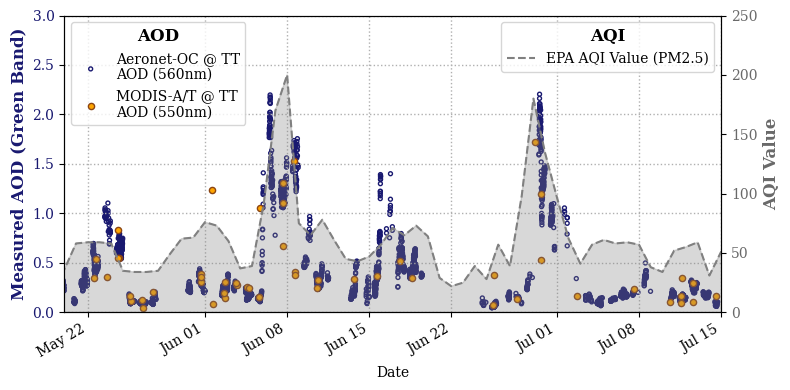

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

# set font
rcParams['font.family'] = 'serif'

wvl = 560
#figure/axis
fig, ax1 = plt.subplots(figsize=(8,4))
#ax1.set_facecolor('whitesmoke')
plt.grid(True, which='both', linewidth=1,zorder = 0,linestyle=':')
ax1.grid(True, which='both', axis='x', linewidth=1,linestyle=':',zorder = 0)

ax1.set_xlabel('Date')
ax1.set_ylabel(f'Measured AOD (Green Band)', color='midnightblue', fontsize = 12,fontweight='bold')
ax1.tick_params(axis='y', labelcolor='midnightblue')
ax1.set_ylim(0, 3)
ax2 = ax1.twinx()

bothFlag = False
# Plot the AQI Value line and shade under it
if(bothFlag): 
    ax2.plot(aqi['Date'], aqi[' AQI Value'],  linestyle='-', color='gray', label='AQI Value',zorder = 0)
    ax2.fill_between(aqi['Date'], aqi[' AQI Value'], color='gray', alpha=0.3,zorder = -1)  # Shading under the line
else: 
    ax2.plot(aqi['Date'], aqi['PM2.5 AQI Value'],  linestyle='--', color='grey', label='EPA AQI Value (PM2.5)',zorder = 0)
    ax2.fill_between(aqi['Date'], aqi['PM2.5 AQI Value'], color='grey', alpha=0.3,zorder = -1)  # Shading under the line

# plot aeronet
ax1.scatter(aero['Datetime'], aero[f'AOD_{wvl}nm'], edgecolor='midnightblue', facecolor = 'none', s=8, alpha=1, label=f'Aeronet-OC @ TT\nAOD ({wvl}nm)',zorder = 1)
# plot modis
modisDf['Datetime'] = pd.to_datetime(modisDf['Datetime'])
ax1.scatter(modisDf['Datetime'], modisDf[f'AOD_550'], color='saddlebrown', facecolor='orange',  alpha=1, label=f'MODIS-A/T @ TT\nAOD (550nm)', s = 20, zorder = 1)

#formatting.
ax2.set_ylabel('AQI Value', color='dimgrey',  fontsize = 12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='dimgrey')
ax2.set_ylim(0, 250)

#formatting.
fig.autofmt_xdate()  
import matplotlib.dates as mdates
#ax1.xaxis.set_major_locator(mdates.WeekLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.tick_params(axis='x', rotation=45)

# legends
#ax1.legend(loc='upper right')
from matplotlib.font_manager import FontProperties
title_font = FontProperties()
title_font.set_size(12)          # Adjust font size here
title_font.set_weight('bold')    # Optional: make the title bold

#label formatting
ax1_legend = ax1.legend(loc='upper left', fontsize = 10, title = "AOD")
ax1_legend.get_title().set_fontproperties(title_font)
ax2_legend = ax2.legend(loc='upper right', fontsize = 10, title = "AQI")
ax2_legend.get_title().set_fontproperties(title_font)
ax1.set_xlim(pd.to_datetime('2023-05-20'), pd.to_datetime('2023-07-15'))

plt.tight_layout()
plt.show()


/explore/nobackup/people/slsmit34/.nccstmp/ipykernel_2917631/3273420741.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aero['hour'] = aero['Datetime'].dt.floor('H')


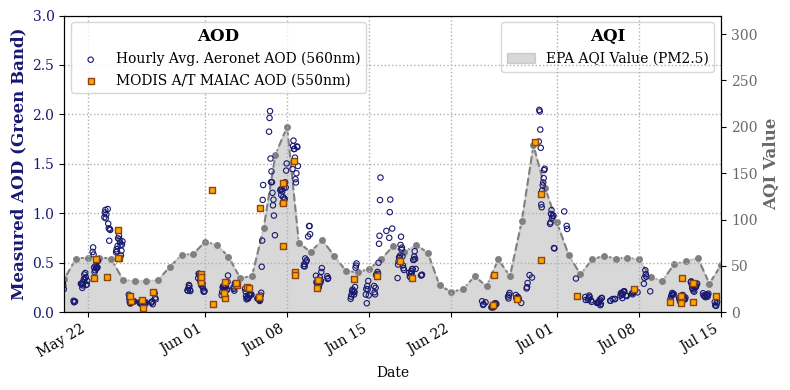

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

# Set global font to Times New Roman
rcParams['font.family'] = 'serif'

wvl = 560
# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(8,4))
#ax1.set_facecolor('whitesmoke')
plt.grid(True, which='both', linewidth=1, zorder=-1, linestyle=':')
#ax1.grid(True, which='both', axis='x', linewidth=1, linestyle=':', zorder=-1)

ax1.set_xlabel('Date')
ax1.set_ylabel(f'Measured AOD (Green Band)', color='midnightblue', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='midnightblue')
ax1.set_ylim(0, 3)

# Create a second y-axis to plot 'AOD_560nm'
ax2 = ax1.twinx()

# Make ax1 transparent
ax1.patch.set_alpha(0)

# Plot AQI data on ax2 first
bothFlag = False
if bothFlag: 
    ax2.plot(aqi['Date'], aqi['AQI Value'], linestyle='-', color='gray', label='AQI Value', zorder=-1)
    ax2.scatter(aqi['Date'], aqi['AQI Value'], facecolor='grey', edgecolor='white', label='AQI Value', zorder=-1)
    ax2.fill_between(aqi['Date'], aqi['AQI Value'], color='gray', alpha=0.3, zorder=-1)
else: 
    ax2.plot(aqi['Date'], aqi['PM2.5 AQI Value'], linestyle='--', color='grey', zorder=-1)
    ax2.scatter(aqi['Date'], aqi['PM2.5 AQI Value'], facecolor='grey', edgecolor='white', zorder=-1)
    ax2.fill_between(aqi['Date'], aqi['PM2.5 AQI Value'], color='grey', alpha=0.3, label='EPA AQI Value (PM2.5)', zorder=-1)

ax2.set_ylabel('AQI Value', color='dimgrey', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='dimgrey')
ax2.set_ylim(0, 320)

# Get hourly average
aero['hour'] = aero['Datetime'].dt.floor('H')
paramToAvgBy = 'hour'
hourly_avg = aero.groupby(paramToAvgBy)[f'AOD_{wvl}nm'].mean().reset_index()
hourly_avg = hourly_avg.reset_index()

# Plot aeronet
#ax1.scatter(hourly_avg[paramToAvgBy], hourly_avg[f'AOD_{wvl}nm'], edgecolor='midnightblue', facecolor='none', s=12, alpha=1, label=f'HOURLY Aeronet-OC AOD ({wvl}nm)', zorder=1)
ax1.scatter(hourly_avg[paramToAvgBy], hourly_avg[f'AOD_{wvl}nm'], edgecolor='midnightblue', facecolor = 'none', linewidths = 0.8, s=15,  label=f'Hourly Avg. Aeronet AOD ({wvl}nm)', alpha=1, zorder=2)
#ax1.plot(hourly_avg[paramToAvgBy], hourly_avg[f'AOD_{wvl}nm'], color='midnightblue', alpha=1, label=f'Daily Avg. Aeronet AOD ({wvl}nm)', zorder=2)


# Plot modis
modisDf['Datetime'] = pd.to_datetime(modisDf['Datetime'])
ax1.scatter(modisDf['Datetime'], modisDf[f'AOD_550'], marker='s', color='saddlebrown', facecolor='orange', alpha=1, label=f'MODIS A/T MAIAC AOD (550nm)', s=20, zorder=3)

# Rotate x-axis ticks for ax1
fig.autofmt_xdate()  # Automatically rotates x-tick labels
# Format x-axis for both ax1 and ax2
import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.tick_params(axis='x', rotation=45)

# Show legends
from matplotlib.font_manager import FontProperties

# Create font properties with the desired size and style
title_font = FontProperties()
title_font.set_size(12)          # Adjust font size here
title_font.set_weight('bold')    # Optional: make the title bold

# Label formatting
ax1_legend = ax1.legend(loc='upper left', fontsize=10, title="AOD")
ax1_legend.get_title().set_fontproperties(title_font)

ax2_legend = ax2.legend(loc='upper right', fontsize=10, title="AQI")
ax2_legend.get_title().set_fontproperties(title_font)

ax1.set_xlim(pd.to_datetime('2023-05-20'), pd.to_datetime('2023-07-15'))
ax1.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2
ax1.patch.set_visible(False) # hide the 'canvas'
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

/explore/nobackup/people/slsmit34/.nccstmp/ipykernel_2917631/1442377888.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aero['hour'] = aero['Datetime'].dt.floor('H')


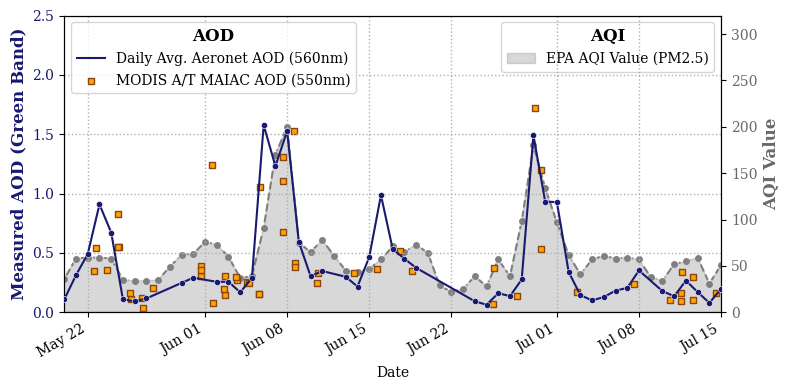

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams

# Set global font to Times New Roman
rcParams['font.family'] = 'serif'

wvl = 560
# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(8,4))
#ax1.set_facecolor('whitesmoke')
plt.grid(True, which='both', linewidth=1, zorder=-1, linestyle=':')
#ax1.grid(True, which='both', axis='x', linewidth=1, linestyle=':', zorder=-1)

ax1.set_xlabel('Date')
ax1.set_ylabel(f'Measured AOD (Green Band)', color='midnightblue', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='midnightblue')
ax1.set_ylim(0, 2.5)

# Create a second y-axis to plot 'AOD_560nm'
ax2 = ax1.twinx()

# Make ax1 transparent
ax1.patch.set_alpha(0)

# Plot AQI data on ax2 first
bothFlag = False
if bothFlag: 
    ax2.plot(aqi['Date'], aqi['AQI Value'], linestyle='-', color='gray', label='AQI Value', zorder=-1)
    ax2.scatter(aqi['Date'], aqi['AQI Value'], facecolor='grey', edgecolor='white', label='AQI Value', zorder=-1)
    ax2.fill_between(aqi['Date'], aqi['AQI Value'], color='gray', alpha=0.3, zorder=-1)
else: 
    ax2.plot(aqi['Date'], aqi['PM2.5 AQI Value'], linestyle='--', color='grey', zorder=-1)
    ax2.scatter(aqi['Date'], aqi['PM2.5 AQI Value'], facecolor='grey', edgecolor='white', zorder=-1)
    ax2.fill_between(aqi['Date'], aqi['PM2.5 AQI Value'], color='grey', alpha=0.3, label='EPA AQI Value (PM2.5)', zorder=-1)

ax2.set_ylabel('AQI Value', color='dimgrey', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='dimgrey')
ax2.set_ylim(0, 320)

# Get hourly average
aero['hour'] = aero['Datetime'].dt.floor('H')
paramToAvgBy = 'Date(dd:mm:yyyy)'
hourly_avg = aero.groupby(paramToAvgBy)[f'AOD_{wvl}nm'].mean().reset_index()
hourly_avg = hourly_avg.reset_index()

# Plot aeronet
#ax1.scatter(hourly_avg[paramToAvgBy], hourly_avg[f'AOD_{wvl}nm'], edgecolor='midnightblue', facecolor='none', s=12, alpha=1, label=f'HOURLY Aeronet-OC AOD ({wvl}nm)', zorder=1)
ax1.scatter(hourly_avg[paramToAvgBy], hourly_avg[f'AOD_{wvl}nm'], facecolor='midnightblue', edgecolor = 'white', linewidths = 0.4, s=20, alpha=1, zorder=3)
ax1.plot(hourly_avg[paramToAvgBy], hourly_avg[f'AOD_{wvl}nm'], color='midnightblue', alpha=1, label=f'Daily Avg. Aeronet AOD ({wvl}nm)', zorder=2)


# Plot modis
modisDf['Datetime'] = pd.to_datetime(modisDf['Datetime'])
ax1.scatter(modisDf['Datetime'], modisDf[f'AOD_550'], marker='s', color='saddlebrown', facecolor='orange', alpha=1, label=f'MODIS A/T MAIAC AOD (550nm)', s=20, zorder=1)

# Rotate x-axis ticks for ax1
fig.autofmt_xdate()  # Automatically rotates x-tick labels
# Format x-axis for both ax1 and ax2
import matplotlib.dates as mdates
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax2.tick_params(axis='x', rotation=45)

# Show legends
from matplotlib.font_manager import FontProperties

# Create font properties with the desired size and style
title_font = FontProperties()
title_font.set_size(12)          # Adjust font size here
title_font.set_weight('bold')    # Optional: make the title bold

# Label formatting
ax1_legend = ax1.legend(loc='upper left', fontsize=10, title="AOD")
ax1_legend.get_title().set_fontproperties(title_font)

ax2_legend = ax2.legend(loc='upper right', fontsize=10, title="AQI")
ax2_legend.get_title().set_fontproperties(title_font)

ax1.set_xlim(pd.to_datetime('2023-05-20'), pd.to_datetime('2023-07-15'))
ax1.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2
ax1.patch.set_visible(False) # hide the 'canvas'
# Adjust layout and show the plot
plt.tight_layout()
output = '/panfs/ccds02/nobackup/people/slsmit34/figs_for_aero_paper/AOD_timeseries.png'
plt.savefig(output, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
output = '/panfs/ccds02/nobackup/people/slsmit34/figs_for_aero_paper/AOD_timeseries.png'
plt.savefig('your_plot.png', dpi=600, bbox_inches='tight)

In [16]:
aero.columns

Index(['Date(dd:mm:yyyy)', 'Time(hh:mm:ss)', 'Day_of_Year',
       'Day_of_Year(Fraction)', 'AOD_1640nm', 'AOD_1020nm', 'AOD_870nm',
       'AOD_865nm', 'AOD_779nm', 'AOD_675nm',
       ...
       'Exact_Wavelengths_of_PW(um)_935nm',
       'Exact_Wavelengths_of_AOD(um)_681nm',
       'Exact_Wavelengths_of_AOD(um)_709nm',
       'Exact_Wavelengths_of_AOD(um)_Empty',
       'Exact_Wavelengths_of_AOD(um)_Empty_9',
       'Exact_Wavelengths_of_AOD(um)_Empty_10',
       'Exact_Wavelengths_of_AOD(um)_Empty_11',
       'Exact_Wavelengths_of_AOD(um)_Empty_12', 'Datetime', 'hour'],
      dtype='object', length=115)

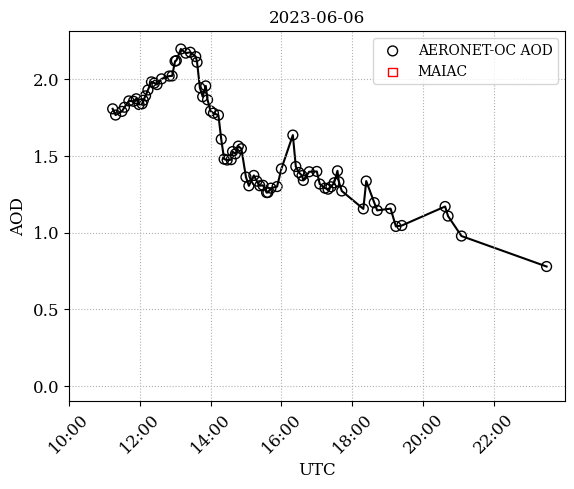

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# Set global font to Times New Roman
rcParams['font.family'] = 'serif'

# Create the figure and axis objects
fig, ax1 = plt.subplots()
plt.grid(True, linestyle=':')

# Example data (replace with your df_aero dataset)
# Plot data
ax1.scatter(aero['Datetime'], aero[f'AOD_{wvl}nm'], facecolors='none', edgecolors='black', s=50, alpha=1, label='AERONET-OC AOD',zorder = 1)
ax1.plot(aero['Datetime'], aero[f'AOD_{wvl}nm'], lw=1.5, alpha=1, c='black', zorder = 0)
ax1.scatter(modisDf['Datetime'], modisDf[f'AOD_550'], edgecolor = 'r', marker = 's', facecolor = 'none', label = 'MAIAC')


# Customize tick parameters
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Set labels, title, and format the x-axis
ax1.set_ylabel('AOD', fontsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
DayStart = '2023-06-06'
DayEnd = '2023-06-06'
plt.xlim(pd.to_datetime(f'{DayStart} 10:00:00 AM'), pd.to_datetime(f'{DayEnd} 11:59:59 PM'))
#ax1.set_ylim(0, 3)
ax1.set_xlabel('UTC', fontsize=12)
plt.title(f'{DayStart}')
plt.legend()
# Display the plot
output = f'/panfs/ccds02/nobackup/people/slsmit34/figs_for_aero_paper/{DayStart}.png'
plt.savefig(output, dpi=600, bbox_inches='tight')
plt.show()


In [18]:
modisDf

,Unnamed: 0,AOD_550,Date,Time,Datetime
0,12,0.544,2023-05-22,1900-01-01 16:45:00,2023-05-22 16:45:00
1,11,0.350,2023-05-22,1900-01-01 13:35:00,2023-05-22 13:35:00
2,13,0.353,2023-05-23,1900-01-01 15:50:00,2023-05-23 15:50:00
3,16,0.554,2023-05-24,1900-01-01 16:30:00,2023-05-24 16:30:00
4,15,0.832,2023-05-24,1900-01-01 14:55:00,2023-05-24 14:55:00
5,14,0.547,2023-05-24,1900-01-01 14:55:00,2023-05-24 14:55:00
6,18,0.113,2023-05-25,1900-01-01 17:10:00,2023-05-25 17:10:00
7,17,0.165,2023-05-25,1900-01-01 15:30:00,2023-05-25 15:30:00
8,20,0.040,2023-05-26,1900-01-01 17:50:00,2023-05-26 17:50:00
9,19,0.121,2023-05-26,1900-01-01 14:40:00,2023-05-26 14:40:00
